In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
!pip install sklearn-ts==0.0.5

# Load data

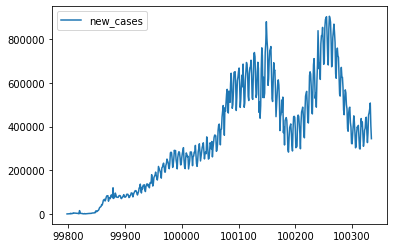

In [3]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [4]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = ['intercept', 'trend', 'log', f'{h}_lag_rolling']
lag_features= []

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek

for lag in [h + i for i in range(14)]:
    dataset[f'{lag}_lag'] = dataset[target].shift(lag)
    lag_features.append(f'{lag}_lag')

dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features + categorical_features + lag_features]
dataset = dataset.dropna()

In [5]:
dataset.head()

,date,new_cases,intercept,trend,log,14_lag_rolling,year,month,dayofweek,14_lag,15_lag,16_lag,17_lag,18_lag,19_lag,20_lag,21_lag,22_lag,23_lag,24_lag,25_lag,26_lag,27_lag
date,,,,,,,,,,,,,,,,,,,,,,,
2020-02-18,2020-02-18,1882.0,1,27,3.332205,1667.214286,2020,2,1,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0,98.0,0.0
2020-02-19,2020-02-19,500.0,1,28,3.367296,1934.714286,2020,2,2,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0,98.0
2020-02-20,2020-02-20,560.0,1,29,3.401197,2153.428571,2020,2,3,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0
2020-02-21,2020-02-21,629.0,1,30,3.433987,2389.642857,2020,2,4,3593.0,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0
2020-02-22,2020-02-22,1761.0,1,31,3.465736,2549.785714,2020,2,5,2734.0,3593.0,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0


In [6]:
from sklearn_ts.validator import check_model

# Neural Networks

## MLPRegressor

{'regressor__early_stopping': True,
 'regressor__hidden_layer_sizes': (100, 100),
 'regressor__learning_rate': 'constant',
 'regressor__learning_rate_init': 0.1,
 'regressor__max_iter': 1000,
 'regressor__n_iter_no_change': 30,
 'regressor__random_state': 42}

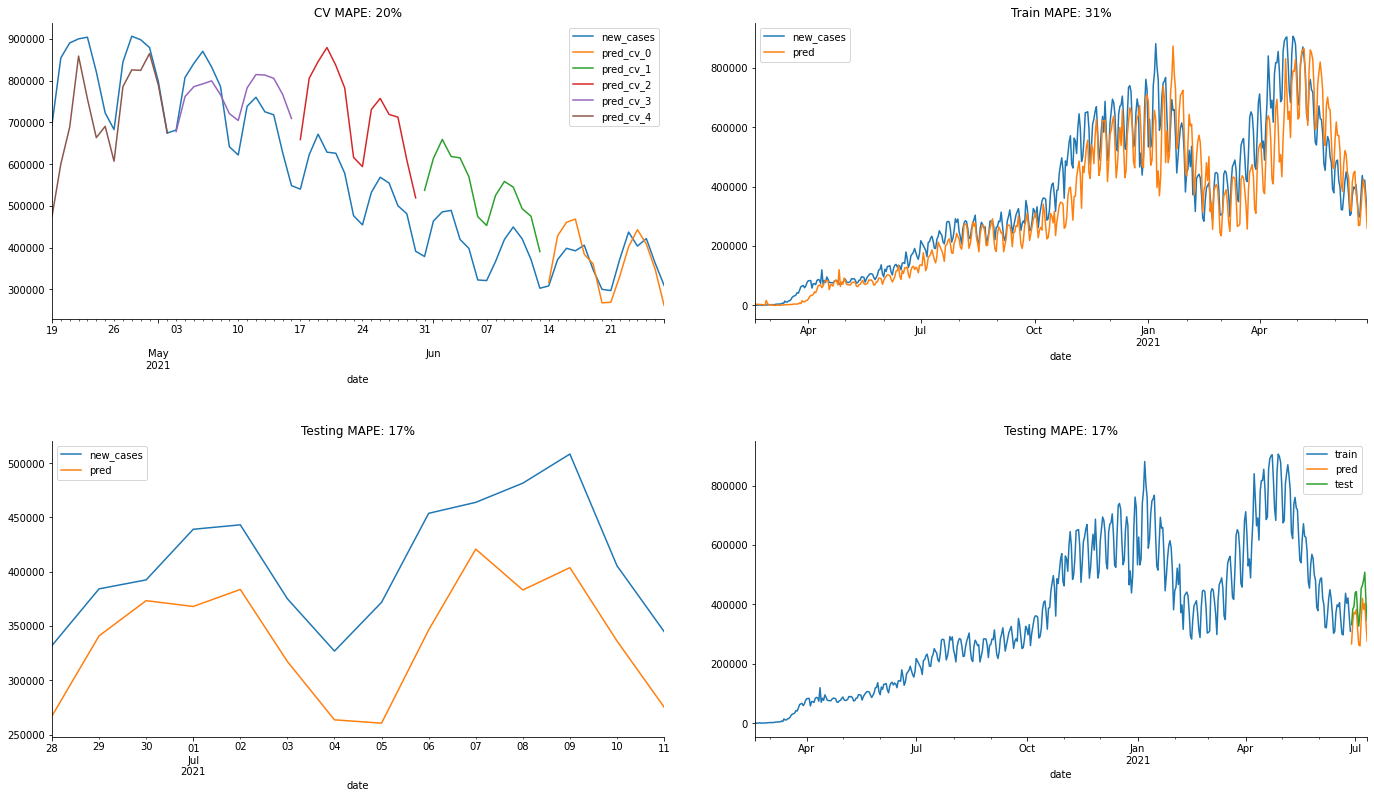

In [7]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

params = {'learning_rate': ['constant', 'invscaling', 'adaptive'], 'learning_rate_init': [0.1, 1], 
          'early_stopping': [True], 'n_iter_no_change': [30], 'max_iter': [1000], 'hidden_layer_sizes': [(100, 100), (100, 100, 100)], 
          'random_state': [42]}

regressor = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', 
                         alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                         max_iter=200, shuffle=True, random_state=42, early_stopping=False, 
                         validation_fraction=0.1, n_iter_no_change=10)

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features, user_transformers=[('mm', MinMaxScaler())])
results['best_params']

In [8]:
!pip install keras-tcn
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Custom NN regressors

### ANN

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin

class ANNRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, learning_rate=0.001, loss='mean_squared_error'):
        self.loss = loss
        self.learning_rate = learning_rate

        self.history = None
        self.model = None

    def fit(self, X, y):
        model = Sequential()
        model.add(Dense(12, input_dim=X.shape[1], activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

        adam = Adam(learning_rate=self.learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam)

        es = EarlyStopping(monitor='val_loss', patience=20)
        self.history = model.fit(X, y, epochs=100, batch_size=10, verbose=0, validation_split=0.1)

        self.model = model
        return self

    def predict(self, X):
        return np.squeeze(self.model.predict(X))

    def get_params(self, deep=True):
        return {'loss': self.loss, 'learning_rate': self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


{'regressor__loss': 'mean_squared_error'}

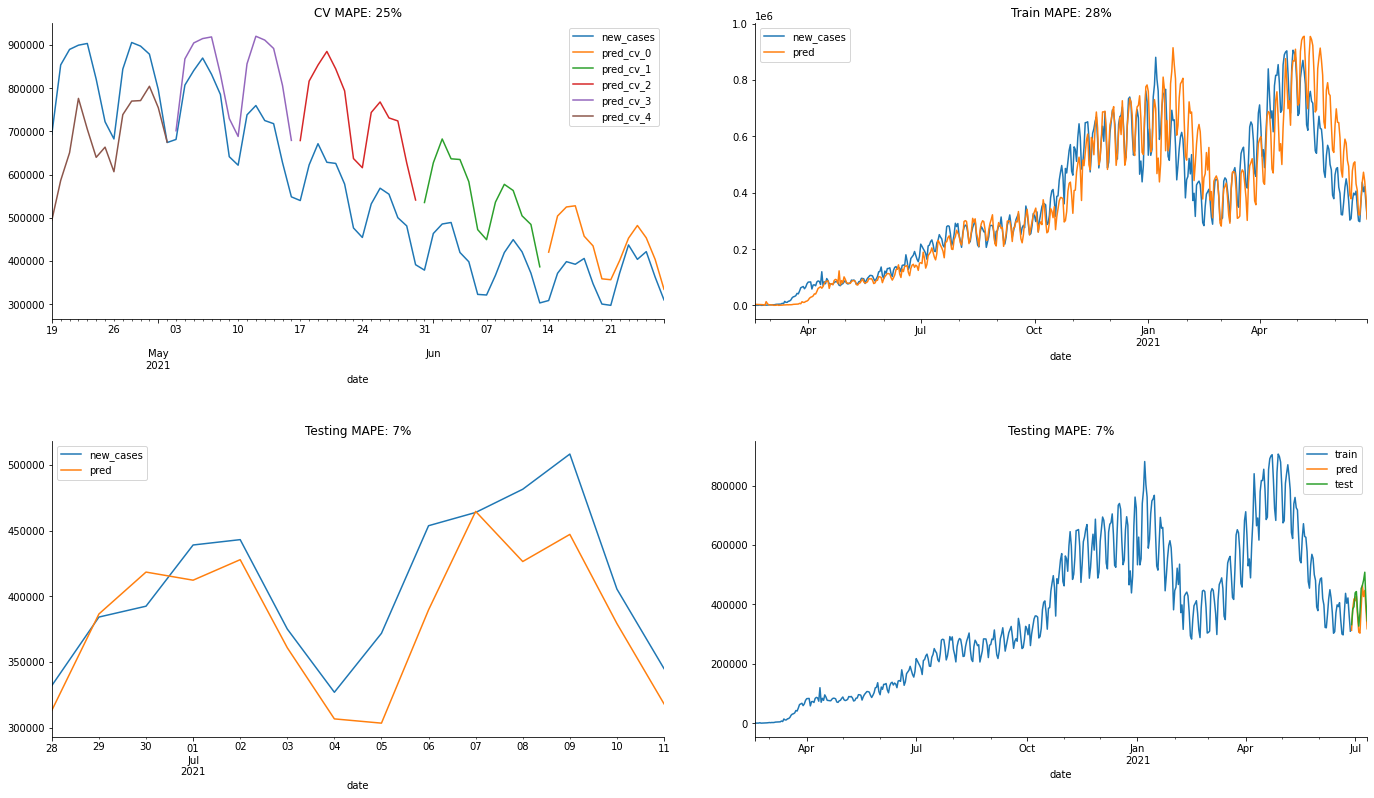

In [11]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

params = {'loss': ['mean_squared_error']}

regressor = ANNRegressor()

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features, user_transformers=[('mm', MinMaxScaler())])
results['best_params']

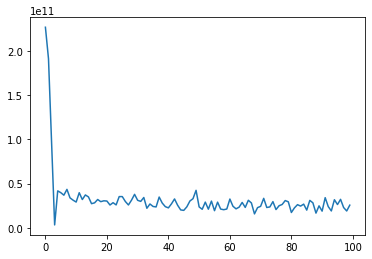

In [12]:
pd.Series(results['model'].named_steps['regressor'].history.history['val_loss']).plot()

### LSTM

In [13]:
#https://keras.io/api/layers/recurrent_layers/lstm/
from keras.layers import LSTM


class LSTMRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, learning_rate=0.001, loss='mean_squared_error'):
        self.loss = loss
        self.learning_rate = learning_rate

        self.history = None
        self.model = None

    def fit(self, X, y):
        model = Sequential()
        # model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32, activation='relu'))  # , input_shape=(X.shape[1], 1)
        model.add(Dense(1))

        adam = Adam(learning_rate=self.learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam)

        # reshape input to be [samples, time steps, features]
        reshaped_X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        reshaped_y = np.reshape(y.values, (y.shape[0], 1))

        es = EarlyStopping(monitor='val_loss', patience=20)
        self.history = model.fit(reshaped_X, reshaped_y,
                                 epochs=400, batch_size=1, verbose=0, callbacks=[es], validation_split=0.1)

        self.model = model
        return self

    def predict(self, X):
        # TODO train and predict several times to have average
        reshaped_X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return np.squeeze(self.model.predict(reshaped_X))

    def get_params(self, deep=True):
        return {'loss': self.loss, 'learning_rate': self.learning_rate}

In [ ]:
from sklearn.preprocessing import MinMaxScaler


params = {'learning_rate': [0.001]}

regressor = LSTMRegressor()

results = check_model(regressor, params, dataset, features=lag_features, categorical_features=[], user_transformers=[('mm', MinMaxScaler())])
results['best_params']

### TCN

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

# https://github.com/philipperemy/keras-tcn
class TCNRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, learning_rate=0.001, loss='mean_squared_error'):
        self.loss = loss
        self.learning_rate = learning_rate

        self.history = None
        self.model = None

    def fit(self, X, y):
        tcn_layer = TCN(input_shape=(X.shape[1], 1))

        m = Sequential([
            tcn_layer,
            Dense(1)
        ])

        adam = Adam(learning_rate=self.learning_rate)
        m.compile(optimizer=adam, loss='mse')

        reshaped_X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        reshaped_y = np.reshape(y.values, (y.shape[0], 1))

        es = EarlyStopping(monitor='val_loss', patience=20)
        self.history = m.fit(reshaped_X, reshaped_y, epochs=500, validation_split=0.1, verbose=0, callbacks=[es])

        self.model = m
        return self

    def predict(self, X):
        reshaped_X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return np.squeeze(self.model.predict(reshaped_X))

    def get_params(self, deep=True):
        return {'loss': self.loss, 'learning_rate': self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [ ]:
params = {'learning_rate': [0.001, 0.01]}

regressor = TCNRegressor()

results = check_model(regressor, params, dataset, features=lag_features, categorical_features=[], user_transformers=[('mm', MinMaxScaler())])
results['best_params']

# Airline

In [ ]:
airline = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
airline.plot()

In [ ]:
h=12
target='Passengers'
features = [f'{h}_lag', f'{2*h}_lag']
airline[f'{h}_lag'] = airline[target].shift(h)
airline[f'{2*h}_lag'] = airline[target].shift(2*h)

In [ ]:
airline.index = pd.to_datetime(airline['Month'])
airline['date'] = pd.to_datetime(airline['Month'])

In [ ]:
X = airline.dropna()[features]
trainX = np.reshape(X.values, (X.shape[0], X.shape[1], 1))

In [ ]:
model = Sequential()
#model.add(LSTM(64, return_sequences=True)) #, stateful=True))
model.add(LSTM(128))
model.add(Dense(1))
adam = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)
#for i in range(100):
#    model.fit(trainX, airline.dropna()[target].values, epochs=1, batch_size=1, verbose=0, shuffle=False)
#    model.reset_states()

model.fit(trainX, airline.dropna()[target].values, epochs=200, batch_size=1, verbose=0)

pd.Series(np.squeeze(model.predict(trainX))).plot()

In [ ]:
airline = airline.dropna()
airline['pred'] = np.squeeze(model.predict(trainX))
airline.plot(x='Month', y=[target, 'pred'])

In [ ]:
params = {'loss': ['mean_squared_error']}

regressor = LSTMRegressor()

results = check_model(regressor, params, airline.dropna(), features=features, 
                      categorical_features=[], user_transformers=[('mm', MinMaxScaler())], h=12, target=target, n_splits=2)
results['best_params']